The fold caustic expansion to first order satisfies (https://ui.adsabs.harvard.edu/abs/1986ApJ...310..568B/abstract )

$$\tau(x_I,y_I) = \tau_0 + \tau_x x_I + \tau_y y_I\\
+\frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2}\tau_{yy} y_I^2 + \tau_{xy}(\tau_{xx},\tau_{yy}) x_I y_I\\
+\frac{1}{3!} \tau_{xxx} x_I^2\,,$$

where the first three terms can be set to zero, without loss of generality, because (a) the overall fermat potential $\tau_0$ is not directly measurable, and (b) we can define the image-plane coordinate system such that the potential is expanded at the origin and the origin maps to the origin in the source plane (i.e., $\vec \theta_0=\vec \beta_0=\vec \theta_0-\vec \alpha_0=(0,0)$).


Here the potential is expanded at around the critical point such that $\det |\partial \vec \beta/\partial \vec \theta|=0$, which yields $\tau_{xy}(\tau_{xx},\tau_{yy})=\pm (\tau_{xx} \tau_{yy})^{1/2}$. The effective fermat potential is then

$$\tau(x_I,y_I) = \frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2!}\tau_{yy} y_I^2 + (\tau_{xx}\tau_{yy})^{1/2} x_I y_I +\frac{1}{3!} \tau_{xxx} x_I^3\,,$$

which is equivalent to expanding the deflection potential as

$$\psi(x_I,y_I) =\frac{1}{2!}\psi_{xx} x_I^2 + \frac{1}{2!}\psi_{yy} y_I^2 + ((1-\psi_{xx})(1-\psi_{yy}))^{1/2} x_I y_I +\frac{1}{3!} \psi_{xxx} x_I^3 $$

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import herculens as hcl
import helens
import pylab as plt
from lens_mass_models import FoldCausticPotential
import scienceplots
plt.style.use(['science','ieee'])
# Enable jax double precision:
jax.config.update('jax_enable_x64', True)

/home/user/.local/share/mamba/envs/herculens-fim-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
hcl.PixelGrid(nx, ny, transform_pix2angle, ra_at_xt_0, dec_at_xy_0)

Init signature:
hcl.PixelGrid(
    nx,
    ny,
    transform_pix2angle=None,
    ra_at_xy_0=None,
    dec_at_xy_0=None,
)
Docstring:      class that manages a specified pixel grid (rectangular at the moment) and its coordinates
Init docstring:
:param nx: number of pixels in x-axis
:param ny: number of pixels in y-axis
:param transform_pix2angle: 2x2 matrix, mapping of pixel to coordinate
:param ra_at_xy_0: ra coordinate at pixel (0,0)
:param dec_at_xy_0: dec coordinate at pixel (0,0)
File:           ~/.local/share/mamba/envs/herculens-fim-project/lib/python3.11/site-packages/herculens/Coordinates/pixel_grid.py
Type:           type
Subclasses:     

In [9]:
kwargs_lens_list = [{"psixx": 0.91, "psiyy": -0.1, "psixxx": -0.1}]
lens_mass_model = hcl.MassModel([FoldCausticPotential()]) # Define the fold caustic lens

In [10]:
# Create grid:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
grid_x, grid_y = jnp.meshgrid(jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100))
x, y = grid_x.flatten(), grid_y.flatten()
# Compute the magnifications:
mu = lens_mass_model.magnification(x, y, kwargs_lens_list)
Mu = mu.reshape(grid_x.shape)
# Compute the image positions:
x_src, y_src = 0.05, 0.0
image_positions = fold_caustic_potential.image_positions(x_src, y_src, **kwargs_lens_list[0])
# Compute numerically
ray_shooting_func = lens_mass_model.ray_shooting
lens_eq_solver = helens.LensEquationSolver(grid_x, grid_y, ray_shooting_func)
beta   = jnp.array([x_src, y_src])
img, src = lens_eq_solver.solve(beta, kwargs_lens_list, nsolutions=2, niter=5, nsubdivisions=8)

In [ ]:
# Use the herculens pixel grid

In [11]:
# Compute the inverse magnification tensor at the origin:
A = jnp.diag(jnp.ones(2)) - jnp.array(lens_mass_model.hessian(0, 0, kwargs_lens_list)).reshape(2,2)
# Compute the eigenvectors:
eigenvalues, eigenvectors = np.linalg.eig(A)
eigenvectors@jnp.diag(eigenvalues)@jnp.linalg.inv(eigenvectors)-A
v1, v2 = eigenvectors[:,0], eigenvectors[:,1]
v1, v2 = v1.real, v2.real # Make into real-valued
v1, v2

(array([-0.96144149, -0.27500955]), array([ 0.27500955, -0.96144149]))

In [12]:
# Compute the inverse magnification tensor at the origin:
A = jnp.diag(jnp.ones(2)) - jnp.array(lens_mass_model.hessian(0, 0, kwargs_lens_list)).reshape(2,2)
# Compute the eigenvectors:
eigenvalues, eigenvectors = np.linalg.eig(jnp.linalg.inv(A))
eigenvectors@jnp.diag(eigenvalues)@jnp.linalg.inv(eigenvectors)-A
v1, v2 = eigenvectors[:,0], eigenvectors[:,1]
v1, v2 = v1.real, v2.real # Make into real-valued
v1, v2

(array([-0.96144149, -0.27500955]), array([ 0.27500955, -0.96144149]))

/tmp/ipykernel_1173611/861772930.py:7: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(image_positions[:,0], image_positions[:,1], marker='x', color='cyan', s=50, edgecolor='black', label='Images (analytic)') # Images


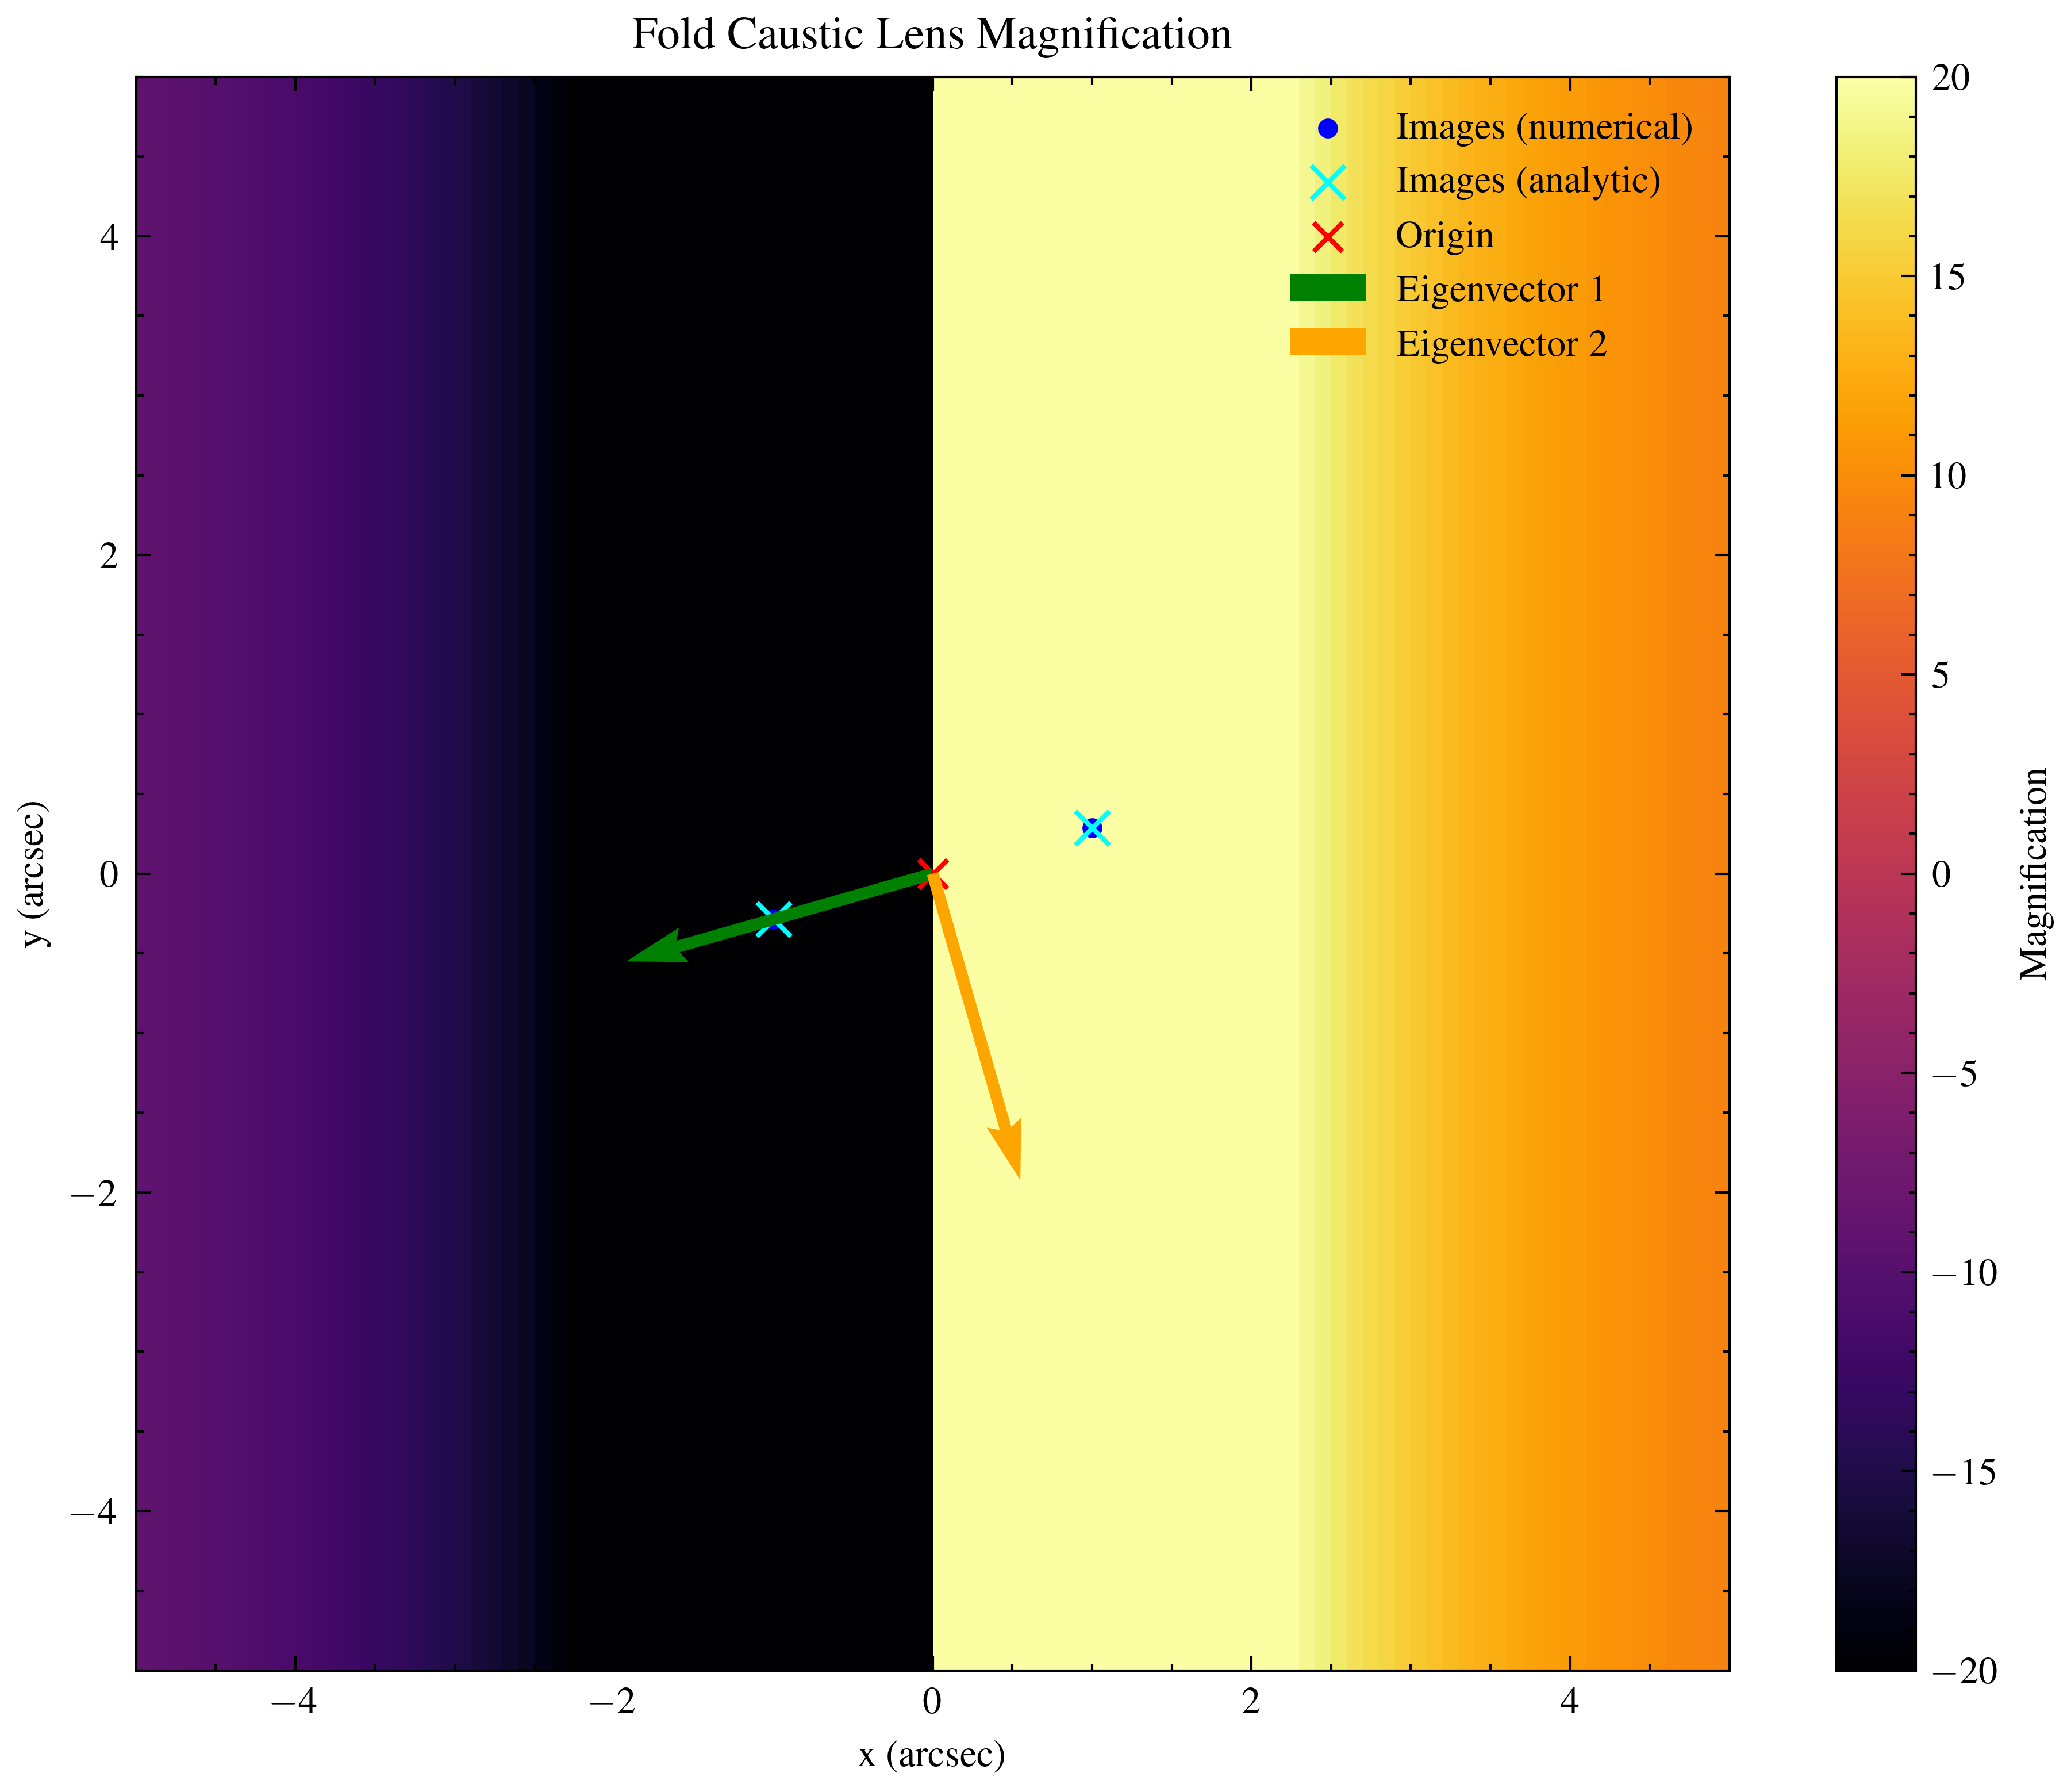

In [13]:
# Plot the absolute value of the magnification, the image positions, and eigenvectors:
plt.figure(figsize=(8, 6))
im = plt.imshow(Mu, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='inferno', vmin=-20, vmax=20) # Magnifications
cbar = plt.colorbar(im)
cbar.set_label('Magnification')
plt.scatter(img[:,0], img[:,1], color='blue', s=10, label='Images (numerical)') # Images
plt.scatter(image_positions[:,0], image_positions[:,1], marker='x', color='cyan', s=50, edgecolor='black', label='Images (analytic)') # Images
plt.scatter(0,0, marker='x', color='red', label='Origin') # Source positions
# Plot eigenvectors from 0:
plt.quiver(0, 0, v1[0], v1[1], color='green', scale=5, label='Eigenvector 1')
plt.quiver(0, 0, v2[0], v2[1], color='orange', scale=5, label='Eigenvector 2')
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.title('Fold Caustic Lens Magnification')
plt.legend()
plt.show()

In [14]:
# Check if the images satisfy the lens equation:
thetap = jnp.array([image_positions[0][0], image_positions[0][1]])
thetam = jnp.array([image_positions[1][0], image_positions[1][1]])
gradp  = lens_mass_model.alpha(thetap[0], thetap[1], kwargs_lens_list) # Deflection at thetap
gradm  = lens_mass_model.alpha(thetam[0], thetam[1], kwargs_lens_list) # Deflection at thetam
print(thetap-beta-gradp)
thetap = jnp.array([img[0][0], img[0][1]])
thetam = jnp.array([img[1][0], img[1][1]])
gradp  = lens_mass_model.alpha(thetap[0], thetap[1], kwargs_lens_list) # Deflection at thetap
gradm  = lens_mass_model.alpha(thetam[0], thetam[1], kwargs_lens_list) # Deflection at thetam
print(thetap-beta-gradp)

[0. 0.]
[ 4.99600361e-15 -1.12132525e-14]
